In [1]:
import pickle
import re
import ujson as json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from pprint import pprint
from tqdm import tqdm


font = {"family" : "Times New Roman",
        "size"   : 14,
        "weight": "bold"}
plt.rc("font", **font)


colors = [(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

### Clean Text

In [582]:
with open("../data/arg_impact/argument_impact.pkl", "rb") as f:
    data = pickle.load(f)

In [583]:
data["test_X"][1071]

{'claim_text': "There is no evidence his policies are any more brutal, inhumane or racially motivated that Obama's, given Obama isolated children from their parents and kept those children in cages. Trump is simply more effective at dealing with people who have criminally entered the country.",
 'path': ["Trump's attempts to reduce both legal and illegal immigration appears inhumane, and clearly racially motivated, to the degree that it is liable to have a damaging impact on America's future.",
  'With over 40k sealed indictments its fair to say he is trying to tackle systemic corruption like no other. \nIndictments Master List',
  "Trump's cabinet choices were chiefly opponents of the offices they hold. They are corruptive forces. Several campaign managers are in prison for various crimes, and even Trump's family is under suspicion. www.npr.org www.edfaction.org en.wikipedia.org www.insidesources.com www.cnn.com en.wikipedia.org",
  'He has certainly not shown good judgement and/or th

### Load Stance

In [872]:
stance_labels = [
    "<none>", "<pro>", "<con>"
]

In [873]:
with open("../data/arg_spec_stance/argument_specificity_stance.pkl", "rb") as f:
    stance = pickle.load(f)

In [874]:
argument_id = dict()
for _id, arg in stance["id_argument"].items():
    argument_id[arg] = _id

In [875]:
stc = dict()
for v in stance["child_parent_stance"].values():
    stc.update(v)
stance = stc

### Load Discourse

In [876]:
INF = 1e30
_INF = -1e30

In [877]:
with open("../data/arg_impact/train_discourse.jsonl", "r") as f:
    train_disco = []
    for x in f:
        x = json.loads(x)
        train_disco.append(x)
        
with open("../data/arg_impact/valid_discourse.jsonl", "r") as f:
    valid_disco = []
    for x in f:
        x = json.loads(x)
        valid_disco.append(x)

with open("../data/arg_impact/test_discourse.jsonl", "r") as f:
    test_disco = []
    for x in f:
        x = json.loads(x)
        test_disco.append(x)

In [878]:
discourse_labels = [
    "<Null>",
    "<Concession>", "<Contrast>",
    "<Reason>", "<Result>", "<Condition>",
    "<Alternative>", "<ChosenAlternative>", "<Conjunction>", "<Exception>", "<Instantiation>", "<Restatement>",
    "<Precedence>", "<Succession>", "<Synchrony>"
]

In [879]:
np.array(train_disco[0]["discourse"]).argmax(axis=1)

array([ 1, 10,  1])

### Generate Paths

In [880]:
impact_labels = ["IMPACTFUL", "MEDIUM IMPACT", "NOT IMPACTFUL"]

In [881]:
train = []
for i, (x, y) in tqdm(enumerate(zip(data["train_X"], data["train_y"]))):
    _id = "train_%d" % (i)
    text = [x["claim_text"]]
    context = x["path"][::-1]
    
    stc = ["<null>"]
    for z in context[1:] + text:
        if z in argument_id:
            stc.append("<%s>" % (stance[argument_id[z]][1]))
        else:
            stc.append("<unk>")

    disco = [[0.0] * len(discourse_labels)]
    disco[0][0] = INF
    for d in train_disco[i]["discourse"]:
        disco.append([_INF] + d)
            
    train.append({
        "id": _id,
        "text": text,
        "context": context,
        "label": y,
        "stance_label": stc,
        "discourse_label": [discourse_labels[z] for z in np.array(disco).argmax(axis=1)],
        "discourse_logit": disco
    })
    
valid = []
for i, (x, y) in tqdm(enumerate(zip(data["val_X"], data["val_y"]))):
    _id = "valid_%d" % (i)
    text = [x["claim_text"]]
    context = x["path"][::-1]
    
    stc = ["<null>"]
    for z in context[1:] + text:
        if z in argument_id:
            stc.append("<%s>" % (stance[argument_id[z]][1]))
        else:
            stc.append("<unk>")
            
    disco = [[0.0] * len(discourse_labels)]
    disco[0][0] = INF
    for d in valid_disco[i]["discourse"]:
        disco.append([_INF] + d)
            
    valid.append({
        "id": _id,
        "text": text,
        "context": context,
        "label": y,
        "stance_label": stc,
        "discourse_label": [discourse_labels[z] for z in np.array(disco).argmax(axis=1)],
        "discourse_logit": disco
    })

test = []
for i, (x, y) in tqdm(enumerate(zip(data["test_X"], data["test_y"]))):
    _id = "test_%d" % (i)
    text = [x["claim_text"]]
    context = x["path"][::-1]
    
    stc = ["<null>"]
    for z in context[1:] + text:
        if z in argument_id:
            stc.append("<%s>" % (stance[argument_id[z]][1]))
        else:
            stc.append("<unk>")
            
    disco = [[0.0] * len(discourse_labels)]
    disco[0][0] = INF
    for d in test_disco[i]["discourse"]:
        disco.append([_INF] + d)

            
    test.append({
        "id": _id,
        "text": text,
        "context": context,
        "label": y,
        "stance_label": stc,
        "discourse_label": [discourse_labels[z] for z in np.array(disco).argmax(axis=1)],
        "discourse_logit": disco
    })

5170it [00:00, 25001.56it/s]
1108it [00:00, 37332.42it/s]
1108it [00:00, 19978.29it/s]


In [882]:
len(valid[0]["context"])

3

In [883]:
valid_disco[0]

{'id': 'valid_0',
 'label': 'IMPACTFUL',
 'discourse': [[-0.5278699994087219,
   1.7553333044052124,
   3.708987236022949,
   1.3934345245361328,
   -3.4603917598724365,
   -2.5592246055603027,
   -0.6017796993255615,
   2.552135944366455,
   -3.3533661365509033,
   0.1725900024175644,
   2.9168059825897217,
   -1.9838616847991943,
   -2.305432081222534,
   -1.2163629531860352],
  [0.2548567056655884,
   2.6281819343566895,
   1.4121912717819214,
   2.7082841396331787,
   -3.547801971435547,
   -2.4750161170959473,
   -1.2365164756774902,
   3.041994571685791,
   -3.4573729038238525,
   0.1875869184732437,
   2.4660634994506836,
   -1.3124133348464966,
   -3.3140718936920166,
   -0.7201653718948364],
  [0.7514098882675171,
   3.020397186279297,
   2.396101474761963,
   1.4136228561401367,
   -3.3063316345214844,
   -2.5815982818603516,
   -0.8488167524337769,
   2.296855926513672,
   -3.2497196197509766,
   0.6410343050956726,
   2.090712547302246,
   -2.4329090118408203,
   -1.9420068

In [884]:
for x in train:
    if "<unk>" in x["stance_label"]:
        print(x["id"])
        for i in range(len(x["stance_label"])):
            if x["stance_label"][i] == "<unk>":
                if i < len(x["context"]):
                    print(i, x["context"][i-1], x["context"][i], sep="|||||")
                else:
                    print(i, x["context"][-1], x["text"][0], sep="-----")
        print()

# the missing topics are at
# https://www.kialo.com/are-identity-politics-detrimental-to-society-7018?path=7018.0~7018.1&active=~7018.1&action=comments, 
# https://www.kialo.com/should-transgender-personae-only-be-performed-by-transgender-people-16846?path=16846.0~16846.1&active=~16846.1&action=comments

train_59
1|||||Identity politics are detrimental to society.|||||Identity politics have given rights to marginalised groups throughout history.
2-----Identity politics have given rights to marginalised groups throughout history.-----Laws are already being implemented under the guise of providing more rights for marginalized groups, which actually impede on others rights, such as Bill C-16 in Canada which amends the Canadian Human Rights Act, and makes it illegal for one to "misgender" an individual, and imposes a discretion on "hate speech" which can easily be used to silence an individual who is addressing a situation from a critical position rather than a position of hate.

train_362
1|||||Identity politics are detrimental to society.|||||Identity politics lead to less open dialogue and progress.
2-----Identity politics lead to less open dialogue and progress.-----Identity politics put grievance at the source of political legitimacy. Because political actors tend to want more, rather

In [885]:
train[59]["stance_label"][1] = "<con>"
train[59]["stance_label"][2] = "<con>"

train[362]["stance_label"][1] = "<pro>"
train[362]["stance_label"][2] = "<pro>"

train[592]["stance_label"][1] = "<pro>"
train[592]["stance_label"][2] = "<con>"

train[1162]["stance_label"][1] = "<pro>"

train[1353]["stance_label"][1] = "<pro>"

train[1868]["stance_label"][1] = "<con>"

train[2289]["stance_label"][1] = "<pro>"
train[2289]["stance_label"][2] = "<con>"

train[2350]["stance_label"][1] = "<con>"

train[2689]["stance_label"][1] = "<con>"
train[2689]["stance_label"][2] = "<pro>"

train[3392]["stance_label"][1] = "<pro>"
train[3392]["stance_label"][2] = "<pro>"

train[4061]["stance_label"][1] = "<pro>"

train[5169]["stance_label"][1] = "<con>"
train[5169]["stance_label"][2] = "<con>"

train[1875]["stance_label"][1] = "<con>"

train[3321]["stance_label"][1] = "<con>"

train[4892]["stance_label"][1] = "<con>"

In [886]:
for x in valid:
    if "<unk>" in x["stance_label"]:
        print(x["id"])
        for i in range(len(x["stance_label"])):
            if x["stance_label"][i] == "<unk>":
                if i < len(x["context"]):
                    print(i, x["context"][i-1], x["context"][i], sep="|||||")
                else:
                    print(i, x["context"][-1], x["text"][0], sep="-----")

# the missing topic is at https://www.kialo.com/are-identity-politics-detrimental-to-society-7018?path=7018.0~7018.1&active=~7018.1&action=comments

valid_336
1|||||Identity politics are detrimental to society.|||||Identity politics are a distraction to more important issues.
2|||||Identity politics are a distraction to more important issues.|||||Issues that negatively affect a group of people based on their identity are an important issue to those people, and thus should be treated as such.
3-----Issues that negatively affect a group of people based on their identity are an important issue to those people, and thus should be treated as such.-----Global issues that affect all groups should be addressed before issues that affect specific social groups.


In [887]:
valid[336]["stance_label"][1] = "<pro>"
valid[336]["stance_label"][2] = "<con>"
valid[336]["stance_label"][3] = "<con>"

In [888]:
for x in test:
    if "<unk>" in x["stance_label"]:
        print(x["id"])
        for i in range(len(x["stance_label"])):
            if x["stance_label"][i] == "<unk>":
                if i < len(x["context"]):
                    print(i, x["context"][i-1], x["context"][i], sep="|||||")
                else:
                    print(i, x["context"][-1], x["text"][0], sep="-----")

# the missing topics are at
# https://www.kialo.com/are-identity-politics-detrimental-to-society-7018?path=7018.0~7018.1&active=~7018.1&action=comments, 
# https://www.kialo.com/should-transgender-personae-only-be-performed-by-transgender-people-16846?path=16846.0~16846.1&active=~16846.1&action=comments

test_272
1|||||Identity politics are detrimental to society.|||||Identity politics prioritize personal experience over factual evidence.
2-----Identity politics prioritize personal experience over factual evidence.-----Identity politics uses both personal experience and factual evidence to change hearts and minds.
test_277
1-----Should a transgender persona only be performed by transgender people?-----A role should be given to the best actor, regardless their gender. A transgender man was assigned female at birth, hence some see no problem in casting a female actor for the role.
test_956
1-----Identity politics are detrimental to society.-----Identity politics lead to less open dialogue and progress.


In [889]:
test[272]["stance_label"][1] = "<pro>"
test[272]["stance_label"][2] = "<con>"

test[956]["stance_label"][1] = "<pro>"

test[277]["stance_label"][1] = "<con>"

In [890]:
import torch as th

logits = th.stack([th.tensor(x["discourse_logit"]).sum(dim=0) for x in train + valid + test], dim=0)


In [891]:
list(zip(discourse_labels, logits.sum(dim=0)))

[('<Null>', tensor(-1.8133e+34)),
 ('<Concession>', tensor(132.3419)),
 ('<Contrast>', tensor(60562.7070)),
 ('<Reason>', tensor(60575.4375)),
 ('<Result>', tensor(46074.3828)),
 ('<Condition>', tensor(-87177.5469)),
 ('<Alternative>', tensor(-61574.5430)),
 ('<ChosenAlternative>', tensor(-14362.0127)),
 ('<Conjunction>', tensor(67708.9219)),
 ('<Exception>', tensor(-84756.4609)),
 ('<Instantiation>', tensor(10543.9658)),
 ('<Restatement>', tensor(64331.2578)),
 ('<Precedence>', tensor(-44775.6250)),
 ('<Succession>', tensor(-73490.7422)),
 ('<Synchrony>', tensor(-27253.0449))]

In [892]:
th.stack([logits[i].mean(dim=0) for i in range(len(logits))]).mean(dim=0)

tensor(-1.6367e+29)

In [893]:
with open("data/arg_impact/train.jsonl", "w") as f:
    for x in tqdm(train):
        f.write(json.dumps(x))
        f.write("\n")

with open("data/arg_impact/valid.jsonl", "w") as f:
    for x in tqdm(valid):
        f.write(json.dumps(x))
        f.write("\n")

with open("data/arg_impact/test.jsonl", "w") as f:
    for x in tqdm(test):
        f.write(json.dumps(x))
        f.write("\n")

100%|██████████| 1108/1108 [00:00<00:00, 17463.66it/s]


In [894]:
print(Counter([x["label"] for x in train]))
print(Counter([x["label"] for x in valid]))
print(Counter([x["label"] for x in test]))

Counter({'IMPACTFUL': 3021, 'NOT IMPACTFUL': 1126, 'MEDIUM IMPACT': 1023})
Counter({'IMPACTFUL': 641, 'NOT IMPACTFUL': 252, 'MEDIUM IMPACT': 215})
Counter({'IMPACTFUL': 646, 'NOT IMPACTFUL': 255, 'MEDIUM IMPACT': 207})


In [781]:
stance_counter = Counter()
for x in test:
    stance_counter.update(x["stance_label"])
print(stance_counter.most_common())

[('<pro>', 1953), ('<con>', 1891), ('<null>', 1108)]


In [782]:
disco_counter = Counter()
for x in train + valid + test:
    disco_counter.update(x["discourse_label"])
print(disco_counter.most_common())

[('<Null>', 7386), ('<Reason>', 6559), ('<Conjunction>', 6421), ('<Contrast>', 5718), ('<Restatement>', 5343), ('<Result>', 1355), ('<Instantiation>', 99), ('<ChosenAlternative>', 23), ('<Precedence>', 1)]


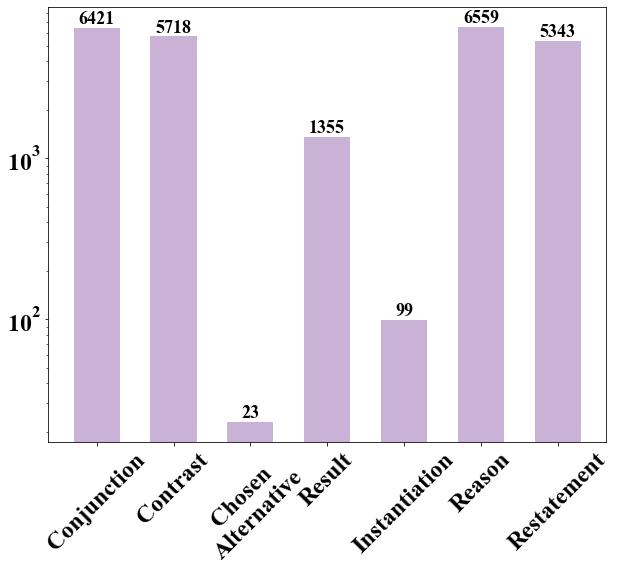

In [783]:
plt.figure(figsize=(10, 8))
labels = ["Conjunction", "Contrast", "Chosen\nAlternative", "Result", "Instantiation", "Reason", "Restatement"]
bar = plt.bar(np.arange(len(labels)), [disco_counter["<%s>" % (x.replace("\n", ""))] for x in labels], width=0.6, color=colors[8])
plt.xticks(list(range(len(labels))), labels, rotation=45, fontsize=24)
plt.yticks([10, 100, 1000, 10000], fontsize=24)
plt.yscale("log")
for rect in bar:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), "%d" % (int(rect.get_height())), ha="center", va="bottom", fontsize=18)
plt.savefig("disco_dist.png", bbox_inches="tight")
plt.show()

[('Conjunction=IMPACTFUL', 1071),
 ('Restatement=IMPACTFUL', 1068),
 ('Reason=IMPACTFUL', 1066),
 ('Contrast=IMPACTFUL', 920),
 ('Conjunction=MEDIUM IMPACT', 567),
 ('Reason=NOT IMPACTFUL', 444),
 ('Restatement=NOT IMPACTFUL', 391),
 ('Contrast=MEDIUM IMPACT', 384),
 ('Conjunction=NOT IMPACTFUL', 363),
 ('Contrast=NOT IMPACTFUL', 350),
 ('Reason=MEDIUM IMPACT', 204),
 ('Restatement=MEDIUM IMPACT', 201),
 ('Result=IMPACTFUL', 140),
 ('Result=NOT IMPACTFUL', 75),
 ('Result=MEDIUM IMPACT', 75),
 ('Instantiation=IMPACTFUL', 37),
 ('Instantiation=MEDIUM IMPACT', 13),
 ('ChosenAlternative=IMPACTFUL', 6),
 ('ChosenAlternative=NOT IMPACTFUL', 5),
 ('Instantiation=NOT IMPACTFUL', 5),
 ('Precedence=MEDIUM IMPACT', 1)]


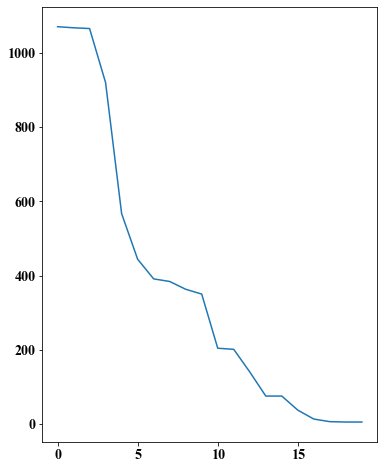

In [784]:
pattern_len = 1
disco_co_occur = Counter()
for x in train + valid + test:
    for i in range(len(x["discourse_label"])-1, max(-1, len(x["discourse_label"])-1-pattern_len), -1):
        d = "-".join(x["discourse_label"][i:]).replace("<", "").replace(">", "")
        l = x["label"].replace("<", "").replace(">", "")
        disco_co_occur["%s=%s" % (d, l)] += 1
        
pprint(disco_co_occur.most_common(300))

plt.figure(figsize=(6, 8))
sorted_disco_co_occur = [x for x in disco_co_occur.most_common() if x[1] >= 5]
# sorted_disco_co_occur = disco_co_occur.most_common()
plt.plot(np.arange(len(sorted_disco_co_occur)), [x[1] for x in sorted_disco_co_occur])
# plt.xticks([x[0] for x in sorted_disco_co_occur])
plt.show()

discos = list(set([x[0].split("=", 1)[0] for x in sorted_disco_co_occur]))

df = pd.DataFrame(np.zeros((len(impact_labels), len(discos))), columns=discos)
df.index = impact_labels

for k, v in sorted_disco_co_occur:
    i, j = k.split("=", 1)
    df[i][j] = float(v)
    

In [785]:
print(df.shape)
df

(3, 7)


,Conjunction,Contrast,ChosenAlternative,Result,Instantiation,Reason,Restatement
IMPACTFUL,1071.0,920.0,6.0,140.0,37.0,1066.0,1068.0
MEDIUM IMPACT,567.0,384.0,0.0,75.0,13.0,204.0,201.0
NOT IMPACTFUL,363.0,350.0,5.0,75.0,5.0,444.0,391.0


In [786]:
df.sum(axis=1)

IMPACTFUL        4308.0
MEDIUM IMPACT    1444.0
NOT IMPACTFUL    1633.0
dtype: float64

In [739]:
# disco_corr = df.div(df.sum(axis=1), axis=0)
# disco_corr = disco_corr.div(disco_corr.sum(axis=0), axis=1)
disco_corr = df.div(df.sum(axis=0), axis=1)

In [740]:
disco_corr

,Conjunction,Contrast,ChosenAlternative,Result,Instantiation,Reason,Restatement
IMPACTFUL,0.535232,0.556227,0.545455,0.482759,0.672727,0.621937,0.643373
MEDIUM IMPACT,0.283358,0.232164,0.000000,0.258621,0.236364,0.119020,0.121084
NOT IMPACTFUL,0.181409,0.211608,0.454545,0.258621,0.090909,0.259043,0.235542


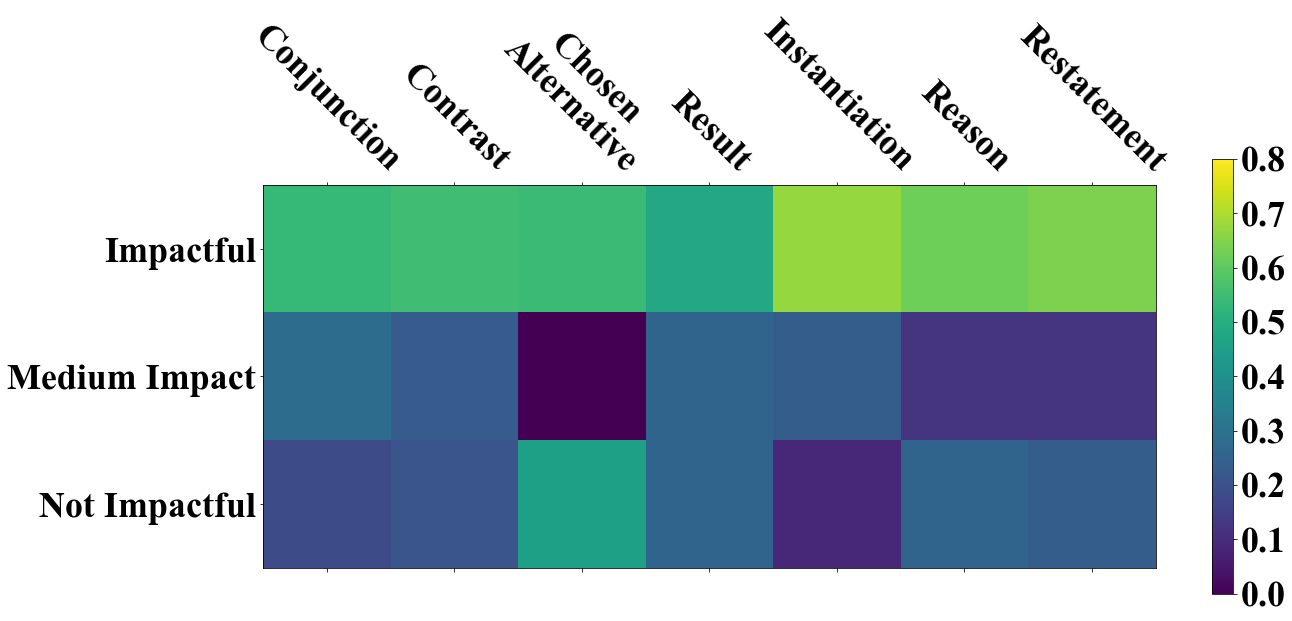

In [746]:
plt.figure(figsize=(20, 8))
plt.matshow(disco_corr, fignum=0)
columns = [x.replace("ChosenAlternative", "Chosen\nAlternative") for x in df.columns]
plt.xticks(range(len(df.columns)), columns, rotation=-45, fontsize=36)
plt.yticks(range(len(df.index)), ["Impactful", "Medium Impact", "Not Impactful"], fontsize=36)
plt.clim(0.0, 0.8)
cbar = plt.colorbar()
for l in cbar.ax.get_yticklabels():
    l.set_fontsize(36)
plt.savefig("disco_corr.png", bbox_inches="tight")
plt.show()

[('pro=IMPACTFUL', 2246),
 ('con=IMPACTFUL', 2062),
 ('con=NOT IMPACTFUL', 887),
 ('pro=NOT IMPACTFUL', 746),
 ('con=MEDIUM IMPACT', 740),
 ('pro=MEDIUM IMPACT', 705)]


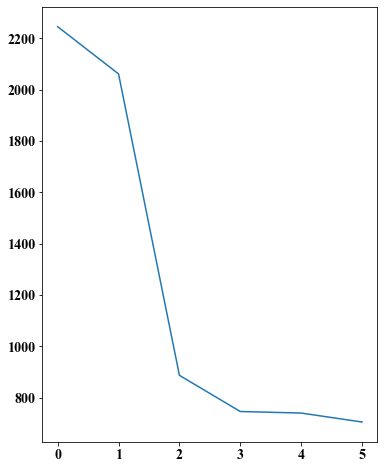

In [749]:
pattern_len = 1
stance_co_occur = Counter()
for x in train + valid + test:
    for i in range(len(x["stance_label"])-1, max(-1, len(x["stance_label"])-1-pattern_len), -1):
        s = "-".join(x["stance_label"][i:]).replace("<", "").replace(">", "")
        l = x["label"].replace("<", "").replace(">", "")
        stance_co_occur["%s=%s" % (s, l)] += 1
        
pprint(stance_co_occur.most_common(300))

plt.figure(figsize=(6, 8))
sorted_stance_co_occur = [x for x in stance_co_occur.most_common() if x[1] >= 5]
# sorted_stance_co_occur = stance_co_occur.most_common()
plt.plot(np.arange(len(sorted_stance_co_occur)), [x[1] for x in sorted_stance_co_occur])
# plt.xticks([x[0] for x in sorted_stance_co_occur])
plt.show()

stances = list(set([x[0].split("=", 1)[0] for x in sorted_stance_co_occur]))

df = pd.DataFrame(np.zeros((len(impact_labels), len(stances))), columns=stances)
df.index = impact_labels

for k, v in sorted_stance_co_occur:
    i, j = k.rsplit("=", 1)
    df[i][j] = float(v)
    

In [750]:
print(df.shape)
df

(3, 2)


,pro,con
IMPACTFUL,2246.0,2062.0
MEDIUM IMPACT,705.0,740.0
NOT IMPACTFUL,746.0,887.0


In [751]:
df.sum(axis=1)

IMPACTFUL        4308.0
MEDIUM IMPACT    1445.0
NOT IMPACTFUL    1633.0
dtype: float64

In [752]:
# stance_corr = df.div(df.sum(axis=1), axis=0)
# stance_corr = stance_corr.div(stance_corr.sum(axis=0), axis=1)
stance_corr = df.div(df.sum(axis=0), axis=1)

In [645]:
stance_corr

,pro,con
IMPACTFUL,0.607520,0.558959
MEDIUM IMPACT,0.190695,0.200596
NOT IMPACTFUL,0.201785,0.240445


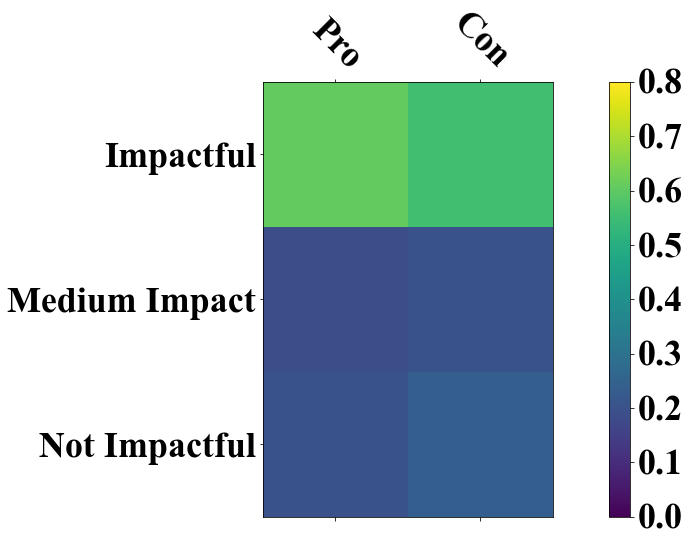

In [754]:
plt.figure(figsize=(20, 8))
plt.matshow(stance_corr, fignum=0)
plt.xticks(range(len(df.columns)), ["Pro", "Con"], rotation=-45, fontsize=36)
plt.yticks(range(len(df.index)), ["Impactful", "Medium Impact", "Not Impactful"], fontsize=36)
plt.clim(0.0, 0.8)
cbar = plt.colorbar()
for l in cbar.ax.get_yticklabels():
    l.set_fontsize(36)
plt.savefig("stance_corr.png", bbox_inches="tight")
plt.show()

[('Contrast=con', 1120),
 ('Conjunction=pro', 1056),
 ('Restatement=pro', 976),
 ('Reason=pro', 948),
 ('Conjunction=con', 945),
 ('Reason=con', 766),
 ('Restatement=con', 684),
 ('Contrast=pro', 534),
 ('Result=con', 157),
 ('Result=pro', 133),
 ('Instantiation=pro', 45),
 ('Instantiation=con', 10),
 ('ChosenAlternative=con', 7),
 ('ChosenAlternative=pro', 4),
 ('Precedence=pro', 1)]


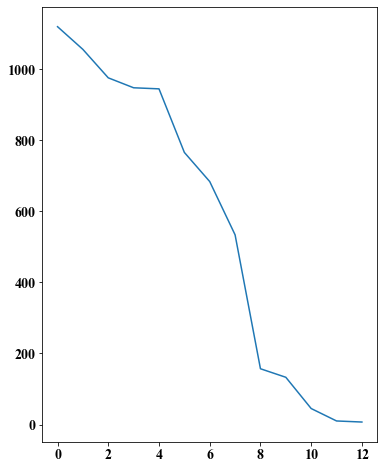

In [765]:
pattern_len = 1
disco_stance_co_occur = Counter()
for x in train + valid + test:
    for i in range(len(x["discourse_label"])-1, max(-1, len(x["discourse_label"])-1-pattern_len), -1):
        d = "-".join(x["discourse_label"][i:]).replace("<", "").replace(">", "")
        s = "-".join(x["stance_label"][i:]).replace("<", "").replace(">", "")
        disco_stance_co_occur["%s=%s" % (d, s)] += 1
        
pprint(disco_stance_co_occur.most_common(300))

plt.figure(figsize=(6, 8))
sorted_disco_stance_co_occur = [x for x in disco_stance_co_occur.most_common() if x[1] >= 5]
# sorted_disco_stance_co_occur = disco_stance_co_occur.most_common()
plt.plot(np.arange(len(sorted_disco_stance_co_occur)), [x[1] for x in sorted_disco_stance_co_occur])
# plt.xticks([x[0] for x in sorted_disco_stance_co_occur])
plt.show()

discos = list(set([x[0].rsplit("=", 1)[0] for x in sorted_disco_stance_co_occur]))
stances = list(set([x[0].rsplit("=", 1)[1] for x in sorted_disco_stance_co_occur]))

df = pd.DataFrame(np.zeros((len(stances), len(discos))), columns=discos)
df.index = list(stances)

for k, v in sorted_disco_stance_co_occur:
    i, j = k.rsplit("=", 1)
    df[i][j] = float(v)
    

In [766]:
print(df.shape)
df

(2, 7)


,Conjunction,Contrast,ChosenAlternative,Result,Instantiation,Reason,Restatement
pro,1056.0,534.0,0.0,133.0,45.0,948.0,976.0
con,945.0,1120.0,7.0,157.0,10.0,766.0,684.0


In [767]:
# stance_corr = df.div(df.sum(axis=1), axis=0)
# stance_corr = stance_corr.div(stance_corr.sum(axis=0), axis=1)
disco_stance_corr = df.div(df.sum(axis=0), axis=1)

In [768]:
disco_stance_corr

,Conjunction,Contrast,ChosenAlternative,Result,Instantiation,Reason,Restatement
pro,0.527736,0.322854,0.0,0.458621,0.818182,0.553092,0.587952
con,0.472264,0.677146,1.0,0.541379,0.181818,0.446908,0.412048


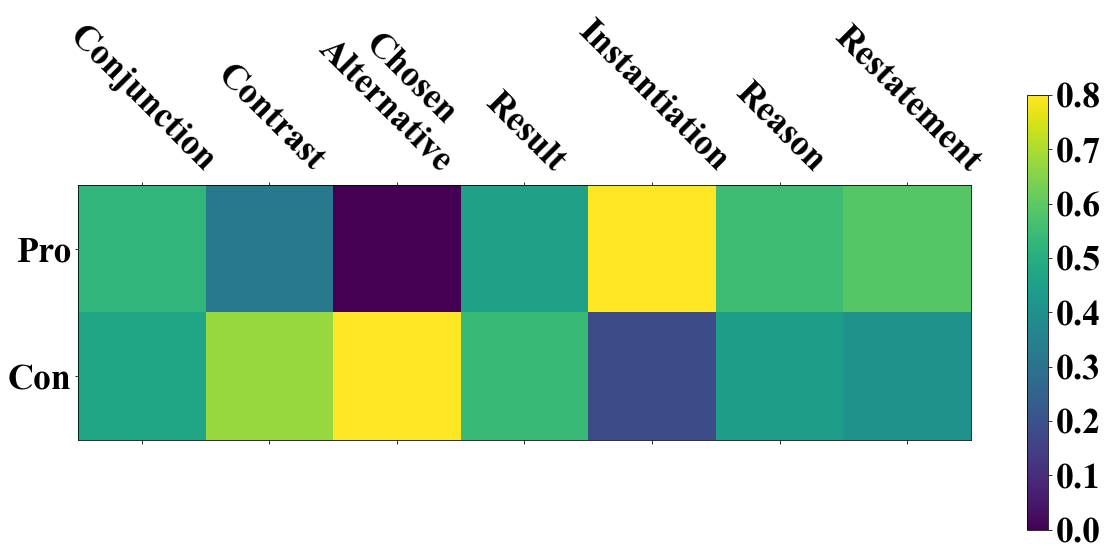

In [769]:
plt.figure(figsize=(20, 8))
plt.matshow(disco_stance_corr, fignum=0)
plt.xticks(range(len(df.columns)), columns, rotation=-45, fontsize=36)
plt.yticks(range(len(df.index)), ["Pro", "Con"], fontsize=36)

plt.clim(0.0, 0.8)
cbar = plt.colorbar()
for l in cbar.ax.get_yticklabels():
    l.set_fontsize(36)
# plt.savefig("disco_stance_corr.png", bbox_inches="tight")
plt.show()

In [770]:
df = pd.DataFrame(np.zeros((3, 1)), columns=["Impact Label\nDistribution"])
df.index = impact_labels

for x in train + valid + test:
    df["Impact Label\nDistribution"][x["label"]] += 1
    

In [771]:
df

,Impact Label\nDistribution
IMPACTFUL,4308.0
MEDIUM IMPACT,1445.0
NOT IMPACTFUL,1633.0


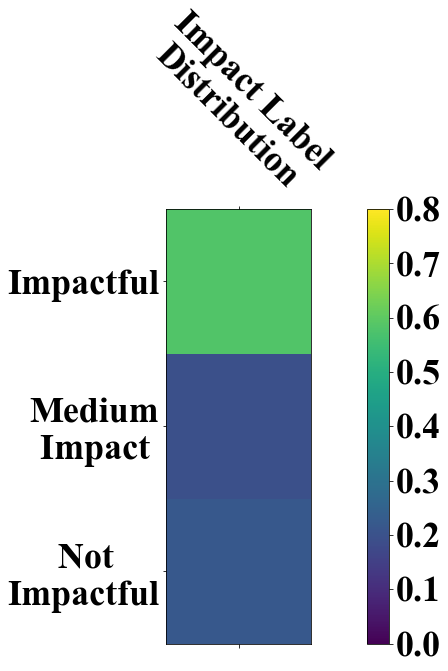

In [778]:
plt.figure(figsize=(20, 8))
plt.matshow(df.div(df.sum(axis=0), axis=1), fignum=0)
plt.xticks(range(len(df.columns)), df.columns, rotation=-45, fontsize=36)
plt.yticks(range(len(df.index)), ["Impactful", "Medium\n Impact ", "Not     \nImpactful"], fontsize=36)

plt.clim(0.0, 0.8)
cbar = plt.colorbar()
for l in cbar.ax.get_yticklabels():
    l.set_fontsize(36)
plt.savefig("label_dist.png", bbox_inches="tight")
plt.show()

In [687]:
sents = set()

In [688]:
train_sents = set()
for x in train:
    train_sents.update(x["text"])
    train_sents.update(x["context"])
        
valid_sents = set()
for x in valid:
    valid_sents.update(x["text"])
    valid_sents.update(x["context"])
        
test_sents = set()
for x in test:
    test_sents.update(x["text"])
    test_sents.update(x["context"])

In [689]:
print(len(train_sents), len(valid_sents), len(test_sents),
    sum([len(train_sents), len(valid_sents), len(test_sents)]),
    len(train_sents | valid_sents | test_sents))

7674 2701 2735 13110 9588


In [690]:
sum([len(x["context"]) + 1 for x in train])

23023

In [691]:
sum([len(x["context"]) + 1 for x in valid])

4930

In [692]:
sum([len(x["context"]) + 1 for x in test])

4952

In [67]:
from itertools import chain
from collections import Counter
Counter(chain.from_iterable([x["stance_label"] for x in train + valid + test]))

Counter({'$none$': 7386, '$con$': 12443, '$pro$': 13047, '$unk$': 29})

In [68]:
train_thesises = set()
for x in train:
    train_thesises.add(x["context"][0])
        
valid_thesises = set()
for x in valid:
    valid_thesises.add(x["context"][0])
        
test_thesises = set()
for x in test:
    test_thesises.add(x["context"][0])

In [71]:
from itertools import chain
from collections import Counter
print("train", Counter(chain.from_iterable([x["stance_label"] for x in train])))
print("valid", Counter(chain.from_iterable([x["stance_label"] for x in valid])))
print("test", Counter(chain.from_iterable([x["stance_label"] for x in test])))

train Counter({'$pro$': 9148, '$con$': 8683, '$none$': 5170, '$unk$': 22})
valid Counter({'$pro$': 1948, '$con$': 1871, '$none$': 1108, '$unk$': 3})
test Counter({'$pro$': 1951, '$con$': 1889, '$none$': 1108, '$unk$': 4})


In [255]:
from itertools import chain

arr = np.array(list(chain.from_iterable([[len(t) for t in x["text"]] + [len(ct) for ct in x["context"]] for x in train + valid + test])))

In [257]:
arr.mean()

117.3720711138125

In [258]:
arr.max()

500

In [700]:

Counter([(len(x["context"]) if len(x["context"]) <=5 else 6) for x in train + valid + test]).most_common()

[(2, 1977), (1, 1524), (6, 1268), (3, 1181), (4, 831), (5, 605)]

In [701]:
(605) / 7386

0.08191172488491741

In [903]:
pattern = ["<Restatement>", "<Reason>"]

pattern_idx = 0
for x in pattern:
    pattern_idx = pattern_idx * 14 + (discourse_labels.index(x) - 1)
print(pattern, pattern_idx)

scores = []
ids = []
for x in train+valid+test:
    if len(pattern) <= len(x["discourse_label"]) - 1:
        array = th.tensor(x["discourse_logit"][-len(pattern):])[:, 1:].softmax(-1)
        if array.shape[0] == 1:
            scores.append(array[pattern_idx].item())
            ids.append(x["id"])
        else:
            o = th.ger(array[0], array[1]).view(-1)
            for i in range(2, array.shape[0]):
                o = th.ger(o, array[i]).view(-1)
            scores.append(o[pattern_idx].item())
            ids.append(x["id"])

['<Restatement>', '<Reason>'] 142


In [904]:
print(len(train), len(valid), len(test))

5170 1108 1108


In [905]:
scores = th.tensor(scores)
sorted_idx = (-scores).argsort()

In [908]:
print(sorted_idx[:10])


tensor([3161, 2690, 2003, 2607, 3499, 4052, 4199, 5030, 1876, 1890])


In [910]:
print([ids[idx] for idx in sorted_idx[:10]])

['train_3970', 'train_3397', 'train_2539', 'train_3290', 'train_4400', 'train_5081', 'valid_102', 'test_44', 'train_2382', 'train_2403']


In [933]:
Counter([train[int(ids[idx].split("_")[1])]["label"] for idx in sorted_idx[:6]])

Counter({'IMPACTFUL': 3, 'NOT IMPACTFUL': 2, 'MEDIUM IMPACT': 1})

In [944]:
print([train[int(ids[idx].split("_")[1])]["context"][0] for idx in sorted_idx[:6]], sep="\n")

['Globalization is a good thing.', 'The European Union should become a United States of Europe', 'Social justice movements should abandon the use of no-platforming at universities', 'The European Union should become a United States of Europe', 'The European Union should become a United States of Europe', 'The U.S. had to use nuclear weapons to achieve its goal of Japan unconditionally surrendering.']


In [942]:
print([train[int(ids[idx].split("_")[1])]["context"][0] for idx in sorted_idx[8:10]])

['Donald Trump is a good President', 'Eating meat is wrong.']


In [936]:
print(test[44]["context"][0])

The electoral college should be abolished.


In [939]:
print(valid[102]["context"][0], valid[102]["label"])

The UK should remain in the EU if a hard Brexit is the only alternative option. IMPACTFUL


In [925]:
print(ids[3499], scores[3499])
train[int(ids[3499].split("_")[1])]

train_4400 tensor(0.2160)


{'id': 'train_4400',
 'text': ['Europeans have a track record of bringing harm to others when they were the most influential global power.'],
 'context': ['The European Union should become a United States of Europe',
  'The USE would take its place as a global player on the international scene.'],
 'label': 'NOT IMPACTFUL',
 'stance_label': ['<null>', '<pro>', '<con>'],
 'discourse_label': ['<Null>', '<Restatement>', '<Reason>'],
 'discourse_logit': [[1e+30,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [-1e+30,
   -1.1880561113357544,
   0.7782547473907471,
   2.9664623737335205,
   1.4466761350631714,
   -3.3021152019500732,
   -2.3806819915771484,
   -0.7460520267486572,
   2.27087140083313,
   -3.1542818546295166,
   -0.2523547112941742,
   3.810153007507324,
   -0.869257926940918,
   -1.906780481338501,
   -1.0022499561309814],
  [-1e+30,
   0.49557483196258545,
   2.2206387519836426,
   3.2639834880828857,
   0.

In [926]:
Counter(chain.from_iterable([x["discourse_label"][1:] for x in train+valid+test if x["context"][0] == 'The European Union should become a United States of Europe']))

Counter({'<Restatement>': 83,
         '<Reason>': 37,
         '<Conjunction>': 20,
         '<Result>': 10,
         '<Contrast>': 12})

In [927]:
Counter([x["discourse_label"][-1] for x in train+valid+test if x["context"][0] == 'The European Union should become a United States of Europe'])

Counter({'<Reason>': 22,
         '<Conjunction>': 18,
         '<Restatement>': 24,
         '<Contrast>': 4,
         '<Result>': 2})

In [929]:
Counter([tuple(x["discourse_label"][-2:]) for x in train+valid+test if x["context"][0] == 'The European Union should become a United States of Europe'])

Counter({('<Restatement>', '<Reason>'): 12,
         ('<Reason>', '<Reason>'): 2,
         ('<Restatement>', '<Conjunction>'): 12,
         ('<Restatement>', '<Restatement>'): 11,
         ('<Null>', '<Restatement>'): 7,
         ('<Reason>', '<Conjunction>'): 2,
         ('<Reason>', '<Restatement>'): 3,
         ('<Result>', '<Reason>'): 1,
         ('<Null>', '<Reason>'): 1,
         ('<Result>', '<Conjunction>'): 4,
         ('<Contrast>', '<Reason>'): 6,
         ('<Contrast>', '<Restatement>'): 1,
         ('<Conjunction>', '<Restatement>'): 2,
         ('<Restatement>', '<Contrast>'): 2,
         ('<Restatement>', '<Result>'): 1,
         ('<Reason>', '<Result>'): 1,
         ('<Result>', '<Contrast>'): 1,
         ('<Reason>', '<Contrast>'): 1})

In [928]:
Counter([x["label"] for x in train+valid+test if x["context"][0] == 'The European Union should become a United States of Europe'])

Counter({'NOT IMPACTFUL': 12, 'IMPACTFUL': 57, 'MEDIUM IMPACT': 1})

In [931]:
Counter([x["label"] for x in train+valid+test if x["context"][0] == 'The European Union should become a United States of Europe' and x["discourse_label"][-2:] == ['<Restatement>', '<Reason>']])

Counter({'NOT IMPACTFUL': 3, 'IMPACTFUL': 8, 'MEDIUM IMPACT': 1})

In [822]:
print(ids[3548], scores[3548])
train[4459]

train_4459 tensor(0.3695)


{'id': 'train_4459',
 'text': ['Crime isn’t solved by the death penalty though. In other words, if it were effective at protecting the public, crime should decrease. It doesn’t.'],
 'context': ['Capital punishment should be abolished in the United States.',
  'Capital punishment protects public safety by ensuring that convicted criminals do not ever offend again.'],
 'label': 'IMPACTFUL',
 'stance_label': ['<null>', '<con>', '<con>'],
 'discourse_label': ['<Null>', '<Reason>', '<Contrast>'],
 'discourse_logit': [[1e+30,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [-1e+30,
   -0.25031667947769165,
   1.9440743923187256,
   4.603143692016602,
   1.978386640548706,
   -3.621002197265625,
   -2.8120765686035156,
   -1.2051892280578613,
   2.8985188007354736,
   -3.555986166000366,
   -0.3591235280036926,
   2.756118059158325,
   -2.4852917194366455,
   -2.4945592880249023,
   -1.0789655447006226],
  [-1e+30,
   1.535693